In [1]:
import pandas as pd
import mlflow
import mlflow.sklearn

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import numpy as np

import subprocess
import json

In [2]:
df=pd.read_csv("../data/creditcard.csv")

In [3]:
input_json = df.iloc[:80].drop(["Time","Class"],axis=1).to_json(orient="split")

## Querying without scaling it

In [5]:
proc = subprocess.run(["curl","-X","POST","-H","Content-Type:application/json; format=pandas-split","--data",input_json,"http://127.0.0.1:1235/invocations"],stdout=subprocess.PIPE,encoding='utf-8')
output=proc.stdout
df2 =pd.DataFrame([json.loads(output)])
df2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31202  100   240  100 30962  21818  2748k --:--:-- --:--:-- --:--:-- 2770k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


In [6]:
y_true =df.iloc[:80].Class
df2=df2.T
eval_acc = accuracy_score(y_true,df2)

y_true.iloc[-1] =1
eval_auc = roc_auc_score(y_true,df2)

print("Eval Acc",eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.6625
Eval AUC 0.3291139240506329


/tmp/ipykernel_59/2808558265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[-1] =1


## Querying with scaling

In [7]:
normal = df[df.Class ==0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly=df[df.Class ==1]

normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size =0.2, random_state=2020)

In [8]:
scaler= StandardScaler()
scaler.fit(pd.concat((normal,anomaly)).drop(["Time","Class"],axis=1))

StandardScaler()

In [10]:
scaled_selection = scaler.transform(df.iloc[:80].drop(["Time","Class"],axis=1))
input_json =pd.DataFrame(scaled_selection).to_json(orient="split")

In [11]:
proc = subprocess.run(["curl","-X","POST","-H","Content-Type:application/json; format=pandas-split","--data",input_json,"http://127.0.0.1:1235/invocations"],stdout=subprocess.PIPE,encoding='utf-8')
output=proc.stdout
preds =pd.DataFrame([json.loads(output)])
preds

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  34285  4397k --:--:-- --:--:-- --:--:-- 4430k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_true =df.iloc[:80].Class
preds=preds.T
eval_acc = accuracy_score(y_true,preds)

y_true.iloc[-1] =1
eval_auc = roc_auc_score(y_true,preds)

print("Eval Acc",eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9875
Eval AUC 0.5


/tmp/ipykernel_59/1766886956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[-1] =1


## Batch Querying

In [13]:
test=df.iloc[:8000]
true =test.Class
test = scaler.transform(test.drop(["Time","Class"],axis=1))
preds=[]

batch_size=80

In [20]:
for f in range(100):
    sample= pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl","-X","POST","-H","Content-Type:application/json; format=pandas-split","--data",sample,"http://127.0.0.1:1235/invocations"],stdout=subprocess.PIPE,encoding='utf-8')
    output=proc.stdout
    resp =pd.DataFrame([json.loads(output)])
    preds=np.concatenate((preds,resp.values[0]))
    
eval_acc = accuracy_score(true,preds)
eval_auc = roc_auc_score(true,preds)

print("Eval Acc",eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  34285  4397k --:--:-- --:--:-- --:--:-- 4430k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31771  100   240  100 31531  26666  3421k --:--:-- --:--:-- --:--:-- 3447k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31721  100   240  100 31481  34285  4391k --:--:-- --:--:-- --:--:-- 4425k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31805  100   240  100 31565  30000  3853k --:--:-- --:--:-- --:--:-- 3882k
  % Total    % Received % Xferd  Average Speed   Tim

Eval Acc 0.9995
Eval AUC 0.9230769230769231


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31763  100   240  100 31523  30000  3848k --:--:-- --:--:-- --:--:-- 3877k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31729  100   240  100 31489  34285  4392k --:--:-- --:--:-- --:--:-- 4426k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31765  100   240  100 31525  34285  4398k --:--:-- --:--:-- --:--:-- 4431k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31812  100   240  100 31572  34285  4404k --:--:-- --:--:-- --:--:-- 4438k


Text(0.5, 1.0, 'Confusion Matrix')

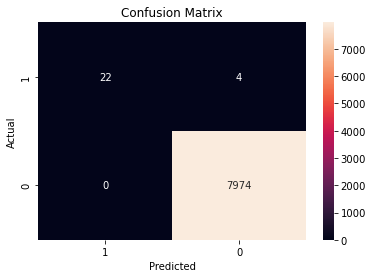

In [21]:
conf_matrix=confusion_matrix(true, preds)
ax=sns.heatmap(conf_matrix,annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")